In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import geopandas as gpd # Library that helps to work with spatial data
import rasterio
from rasterio.transform import Affine
from rasterio.transform import from_origin
from rasterio.features import shapes
import contextily as cx


In [32]:
# read the first h5 file
file_path = "data/h20v03_2023.h5"

viirs_ds = h5py.File(file_path, 'r')
dnb = viirs_ds['HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Covered']

# # replace fill values with 0
dnb_data = dnb[:]
dnb_data[dnb_data == 65535] = 0

# # get the dimensions of the data
# dnb_data.shape


In [33]:
list(viirs_ds.attrs)

['AlgorithmType',
 'AlgorithmVersion',
 'Conventions',
 'DataResolution',
 'DayNightFlag',
 'EastBoundingCoord',
 'EndTime',
 'GRingPointLatitude',
 'GRingPointLongitude',
 'GranuleDayNightFlag',
 'HorizontalTileNumber',
 'InputPointer',
 'LocalGranuleID',
 'LongName',
 'NorthBoundingCoord',
 'NumberofInputGranules',
 'PGENumber',
 'PGEVersion',
 'PGE_EndTime',
 'PGE_Name',
 'PGE_StartTime',
 'PlatformShortName',
 'ProcessVersion',
 'ProcessingCenter',
 'ProcessingEnvironment',
 'ProductionTime',
 'RangeBeginningDate',
 'RangeBeginningTime',
 'RangeEndingDate',
 'RangeEndingTime',
 'SatelliteInstrument',
 'SensorShortname',
 'ShortName',
 'SouthBoundingCoord',
 'StartTime',
 'TileID',
 'VersionID',
 'VerticalTileNumber',
 'WestBoundingCoord',
 'creator_email',
 'creator_name',
 'creator_url',
 'identifier_product_doi',
 'identifier_product_doi_authority',
 'naming_authority',
 'publisher_email',
 'publisher_name',
 'publisher_url']

(4800, 7200)


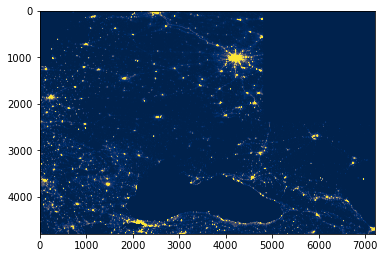

In [2]:
coordinates = ["h20v03", "h20v04", "h21v03", "h21v04", "h22v04"]
# years = ["2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"]
years = ["2023"]
fill_matrix = np.zeros((2400, 2400))
# max_lat = 60.0
# min_lat = 40.0
# max_lon = 50.0
# min_lon = 20.0

xmin, ymin, xmax, ymax =[20.0, 40.0, 50.0, 60.0]

# x = np.linspace(min_lon, max_lon, 2400*3)
# y = np.linspace(min_lat, max_lat, 2400*2)

# 15 arc seconds
resolution = 15 / 3600

transform = from_origin(xmin, ymax, resolution, resolution)

# merge all files per year
for year in years:
    for coord in coordinates:
        # load data
        file_path = f"data/{coord}_{year}.h5"
        annual_grid_h5 = h5py.File(file_path, 'r')
        annual_grid_dnb = annual_grid_h5['HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Free']
        annual_grid_dnb = annual_grid_dnb[:]
        annual_grid_dnb[annual_grid_dnb == 65535] = 0 # replace fill values with 0
        if coord == "h20v03":
            annual_h20v03_dnb = annual_grid_dnb
        elif coord == "h20v04":
            annual_h20v04_dnb = annual_grid_dnb
        elif coord == "h21v03":
            annual_h21v03_dnb = annual_grid_dnb
        elif coord == "h21v04":
            annual_h21v04_dnb = annual_grid_dnb
        elif coord == "h22v04":
            annual_h22v04_dnb = annual_grid_dnb

        # latitudes.append(annual_grid_h5.attrs['NorthBoundingCoord'])
        # latitudes.append(annual_grid_h5.attrs['SouthBoundingCoord'])
        # longitudes.append(annual_grid_h5.attrs['WestBoundingCoord'])
        # longitudes.append(annual_grid_h5.attrs['EastBoundingCoord'])

    # merge data
    annual_dnb = np.vstack((np.hstack((annual_h20v03_dnb, annual_h21v03_dnb, fill_matrix)), 
                             np.hstack((annual_h20v04_dnb, annual_h21v04_dnb, annual_h22v04_dnb))))
    
    print(annual_dnb.shape)
    
    # plot
    cmap = plt.get_cmap('cividis')
    fig =  plt.figure(figsize=(6,6))
    ax = plt.axes()
    ax.imshow(annual_dnb, cmap = cmap, vmin=0, vmax=100)
    plt.show()

    # save as a raster file
    file_path = f"intermediate_data/{year}_dnb.tif"
    with rasterio.open(file_path, 'w', driver='GTiff', height=annual_dnb.shape[0], width=annual_dnb.shape[1], count=1, dtype=annual_dnb.dtype, crs='+proj=latlong', transform=transform) as dst:
        dst.write(annual_dnb, 1)   


In [11]:
# get the number of rows
annual_dnb.shape[0]

x = np.linspace(20, 50, 7200)
y = np.linspace(40, 60, 4800)

In [13]:
X, Y = np.meshgrid(x, y)
X

array([[20.        , 20.00416725, 20.00833449, ..., 49.99166551,
        49.99583275, 50.        ],
       [20.        , 20.00416725, 20.00833449, ..., 49.99166551,
        49.99583275, 50.        ],
       [20.        , 20.00416725, 20.00833449, ..., 49.99166551,
        49.99583275, 50.        ],
       ...,
       [20.        , 20.00416725, 20.00833449, ..., 49.99166551,
        49.99583275, 50.        ],
       [20.        , 20.00416725, 20.00833449, ..., 49.99166551,
        49.99583275, 50.        ],
       [20.        , 20.00416725, 20.00833449, ..., 49.99166551,
        49.99583275, 50.        ]])

In [9]:
# list(viirs_ds.attrs)

# lat_max = viirs_ds.attrs['NorthBoundingCoord']
# lat_min = viirs_ds.attrs['SouthBoundingCoord']
# lon_max = viirs_ds.attrs['EastBoundingCoord']
# lon_min = viirs_ds.attrs['WestBoundingCoord']

# print(lat_max, lat_min, lon_max, lon_min)

# lats = np.linspace(lat_max, lat_min, dnb.shape[1])
# lons = np.linspace(lon_min, lon_max, dnb.shape[0])
# x, y = np.meshgrid(lons, lats)

# cmap = plt.get_cmap('cividis')

# fig =  plt.figure(figsize=(6,6))
# ax = plt.axes()

# ax.pcolormesh(x, y, dnb_data, cmap = cmap, vmin = 0, vmax = 100)
# plt.show()

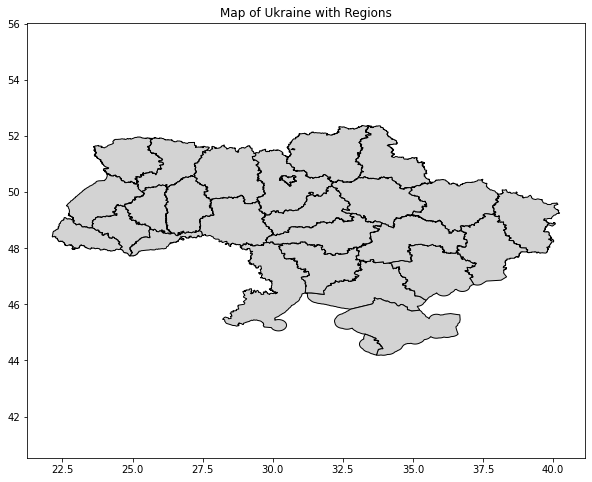

In [10]:
# read the shapefile
ukraine_polygons = gpd.read_file("geoBoundaries-UKR-ADM1.geojson")

fig, ax = plt.subplots(figsize=(10, 8))
ukraine_polygons.plot(ax=ax, color='lightgray', edgecolor='black')
plt.title('Map of Ukraine with Regions')
plt.axis('equal')  # Equal aspect ratio
plt.show()


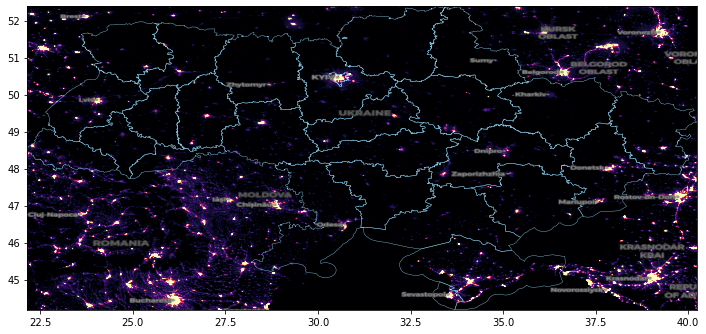

In [8]:
# plot lights for Ukraine in 2023

# load the shapefile, get the bounding box of Ukraine
ukraine_polygons = gpd.read_file("geoBoundaries-UKR-ADM1.geojson")
ukraine_bbox = ukraine_polygons.total_bounds

# read the raster file
raster = rasterio.open("intermediate_data/2023_dnb.tif")
raster_window = raster.window(*ukraine_bbox)
raster_clipped = raster.read(1, window=raster_window)

# plot
fig , ax = plt.subplots(figsize =( 12 ,8))
im = ax.imshow(raster_clipped, extent = ukraine_bbox[[0, 2, 1, 3]], vmin=0, vmax=63, cmap="magma")
# State boundaries are overlayed
ukraine_polygons.boundary.plot(ax=ax, color="skyblue", linewidth=0.4)
cx.add_basemap(ax=ax, crs=ukraine_polygons.crs.to_string(), source = cx.providers.CartoDB.DarkMatterOnlyLabels , 
               attribution = False)





In [11]:
raster_clipped.shape

(1967, 4342)

In [43]:
with rasterio.open("intermediate_data/2023_dnb.tif") as src:
    # Print the CRS (Coordinate Reference System)
    print("CRS:", src.crs)

    # Print the transformation matrix
    print("Transformation matrix:")
    print(src.transform)

    # Print the raster dimensions (width and height)
    print("Dimensions (width, height):", src.width, src.height)

    # Print the number of bands
    print("Number of bands:", src.count)

    # Print the data type of the raster values
    print("Data type:", src.dtypes)

    # Print the bounds of the raster
    print("Bounds:", src.bounds)

CRS: EPSG:4326
Transformation matrix:
| 0.00, 0.00, 20.00|
| 0.00, 0.00, 40.00|
| 0.00, 0.00, 1.00|
Dimensions (width, height): 7200 4800
Number of bands: 1
Data type: ('float64',)
Bounds: BoundingBox(left=19.997916666666665, bottom=59.99791666666667, right=49.99791666666667, top=39.99791666666667)


In [44]:
# Print the bounding box obtained from the shapefile
print("Shapefile Bounding Box:", ukraine_polygons.total_bounds)

# Print the bounds of the raster
print("Raster Bounds:", src.bounds)

Shapefile Bounding Box: [22.137059  44.184598  40.2275801 52.3791473]
Raster Bounds: BoundingBox(left=19.997916666666665, bottom=59.99791666666667, right=49.99791666666667, top=39.99791666666667)


In [14]:
# Assuming xres and yres represent the pixel resolutions of your raster
# raster_xres = xres
# raster_yres = yres

# Assuming you have a shapefile with GeoDataFrame named ukraine_polygons
# Get the bounding box of the shapefile
shapefile_bbox = ukraine_polygons.total_bounds

# Calculate the width and height of the shapefile bounding box
shapefile_width = shapefile_bbox[2] - shapefile_bbox[0]
shapefile_height = shapefile_bbox[3] - shapefile_bbox[1]

# Calculate the resolution of the shapefile in x and y directions
shapefile_xres = shapefile_width / number_of_pixels_in_x_direction
shapefile_yres = shapefile_height / number_of_pixels_in_y_direction


WindowError: Bounds and transform are inconsistent